In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from numpy import savetxt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1c5kb2e0 because the default path (/home/divya/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def sigmoid (x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0- x)

#idiotypic network specific constants
beta=0.03
init_conc=10.0
master_folder='./logs/fr_t1_XOR_top4/'

In [3]:
class XOR_NN:
    def __init__(self,nn):
        self.activation=sigmoid
        self.derivative_act=sigmoid_derivative
        self.layers=len(nn)
        self.steps_per_epoch=1
        self.nn=nn
        self.weights= []
        self.losses=[]
        self.finalloss=[]
        self.bias=[]
        self.conc=[]
        self.concvalues=[]

        for layer in range(self.layers - 1):
            w=2*np.random.rand(nn[layer], nn[layer+1]) - 1
            b=np.random.random(size=(1,nn[layer+1]))
            self.weights.append(w)
            self.bias.append(b)
            concarray=np.ma.array(np.full((nn[layer+1]),init_conc),mask=False)
            self.conc.append(concarray)
            self.losses.append([])
            self.concvalues.append([])

    def _forward_prop(self,x):
        y=[x]
        for i in range(len(self.weights)-1):
            if i==0:
                dotprod=np.dot(x,self.weights[i])
            else:
                dotprod=np.dot(y[i],self.weights[i])
          #dotprod+=self.bias[i]
            activate=self.activation(dotprod)
            y.append(activate)

        #last layer
        dotprod=np.dot(y[-1],self.weights[-1])
        activate=self.activation(dotprod)
        y.append(activate)
        return y

    #here starts the backpropagation
    def _backprop_res(self,y,target,lr,iflag=False):
        error=target-y[-1]
        deltavec=[error*self.derivative_act(y[-1])]
        lerror=error
        lerrorsum=np.sum(error**2)
        errorvec=[lerrorsum]
        esumvecg=[]
        esumvec=[]

        for i in range(self.layers-2,0,-1):
            error=deltavec[-1].dot(self.weights[i].T)
            onlyerror=error
            error=error*self.derivative_act(y[i])
            esumg=abs(np.sum(abs(error),axis=0))
            esum=abs(np.sum((error),axis=0))
            deltavec.append(error)
            errorvec.append(onlyerror)
            esumvec.append(esum)
            esumvecg.append(esumg)

        deltavec.reverse()
        errorvec.reverse()
        esumvec.reverse()
        esumvecg.reverse()
        #print('The errorsum vector is ',esumvec)
        
        #calculating the stimulations and the suppressions before the updation of weights
        for i in range(len(self.weights)-1):
            self.losses[i].append(esumvecg[i].tolist())
            if iflag==True:
                #print('***************************************************')
                #print("the index is ",i)
                #print('losses is ',self.losses)
                #this is the sum of concentration values
                sumc=np.sum(self.conc[i])
                #this is the index of the minimum concentration value
                mini=(np.argmin(esumvecg[i])).item()
                #print('the sum of concentration values is ',sumc)
                #print('min index is ',mini)
                self.conc[i].mask[mini]=True
                #print('conc array after masking ',self.conc[i])
                sti=[]
                deltac=[]
                minsum=beta*(np.sum(self.conc[i])/sumc)
                #print('minsum is ',minsum)
                self.conc[i].mask[mini]=False #after taking the sum setting the mask back to false
                #print('conc array after unmasking ',self.conc[i])
                sti=beta*(self.conc[i]/sumc)
                #print('sti is ',sti)
                self.conc[i].mask[mini]=True
                deltacn=-1*abs(abs(np.sum(esumvecg[i])))*sti
                self.conc[i]+=deltacn
                deltacnmin=abs(1-abs(np.sum(esumvecg[i])))*minsum
                #print('deltacnmin is ',deltacnmin)
                self.conc[i].mask[mini]=False
                self.conc[i][mini]+=deltacnmin
                #self.conc[i] = np.ma.where(self.conc[i] < 30.00, self.conc[i], 30.00)
                #print('after sti and sup conc is ',self.conc[i])
                self.conc[i]=np.ma.array(np.ma.where(self.conc[i]>100.0,100.0,self.conc[i]),mask=False)
                #print('selfconc is ',self.conc[i])
                self.concvalues[i].append((self.conc[i].copy()).tolist())

            #using deep copy
            #self.reshist.append(copy.deepcopy(self.res))
        
        #here now updating the weights
        for i in range(len(self.weights)):
            self.weights[i]+=lr*(y[i].T.dot(deltavec[i]))
            #self.bias[i]+=np.sum(deltavec[i],axis=0,keepdims=True)*lr

        return lerrorsum

    def fit(self,data,labels,learning_rate=0.1,epochs=100000,iflag=False):
        x=data
        for i in range(epochs+1):
            y=self._forward_prop(x)
            #print('y[-1] after forward prop',y[-1])
            error=self._backprop_res(y,labels,learning_rate,iflag)
            self.finalloss.append(error)
            if(i)%5000==0:
                print(f"Error at the epoch {i+1} is {error}")

In [23]:
nn=XOR_NN([2,6,6,1])
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
aoutputs= np.array([[0.0],[1.0],[1.0],[0.0]]) #XOR
#aoutputs= np.array([[0.0],[1.0],[1.0],[1.0]]) #OR
#aoutputs= np.array([[0.0],[0.0],[0.0],[1.0]]) #AND
print('weights are \n',nn.weights)
print('conc is \n',nn.conc)
print('losses is \n',nn.losses)

weights are 
 [array([[ 0.94277161,  0.08238987,  0.05813048, -0.69533693, -0.53768015,
         0.30486914],
       [ 0.2156737 ,  0.15572227,  0.38474302,  0.77631995,  0.56138064,
        -0.4296229 ]]), array([[ 0.96994371,  0.90059268,  0.45006585, -0.89194854,  0.21599234,
         0.7466972 ],
       [ 0.25675453,  0.42806282, -0.75373032, -0.80638122,  0.65194932,
        -0.84593531],
       [-0.79319753,  0.00275819, -0.06095109, -0.59155309, -0.57350428,
        -0.40808077],
       [-0.01112442, -0.75332503,  0.74510257, -0.3410166 ,  0.20371264,
         0.24084882],
       [-0.1717855 , -0.6360742 , -0.89916245,  0.90888142, -0.42887203,
         0.31159743],
       [ 0.87133437, -0.35114525, -0.07677197, -0.13853847,  0.58013508,
        -0.52374812]]), array([[-0.97466268],
       [-0.72315942],
       [ 0.54283076],
       [-0.43325298],
       [-0.94609472],
       [-0.45160099]])]
conc is 
 [masked_array(data=[10.0, 10.0, 10.0, 10.0, 10.0, 10.0],
             mask=[F

In [24]:
nepochs=15000
nn.fit(inputs, aoutputs,epochs=nepochs,iflag=True)

Error at the epoch 1 is 1.4454084983662512
Error at the epoch 5001 is 0.9502447308945294
Error at the epoch 10001 is 0.009755627482004186
Error at the epoch 15001 is 0.0029304371838966875


In [25]:
a=(nn._forward_prop(inputs))
print(a[-1])
#print(nn.losses)
print('concvalues are \n',nn.conc)
#Writing the log files
folder=master_folder+'XOR/'
savetxt(folder+'losses_overall.csv',nn.finalloss,delimiter=',')
savetxt(folder+'losses_h1.csv',nn.losses[0],delimiter=',')
savetxt(folder+'conc_h1.csv',nn.concvalues[0],delimiter=',')
savetxt(folder+'conc_h2.csv',nn.concvalues[1],delimiter=',')
savetxt(folder+'losses_h2.csv',nn.losses[1],delimiter=',')

[[0.0300714 ]
 [0.97332453]
 [0.97297668]
 [0.02416315]]
concvalues are 
 [masked_array(data=[19.418150289452417, 5.680336507332594,
                   46.86449370542062, 100.0, 6.236038019601238,
                   47.45913603519164],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20), masked_array(data=[3.315952995505391, 100.0, 3.315952995505391,
                   3.4863537226599184, 3.315952995505391,
                   31.46974530863645],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20), masked_array(data=[10.0],
             mask=[False],
       fill_value=1e+20)]


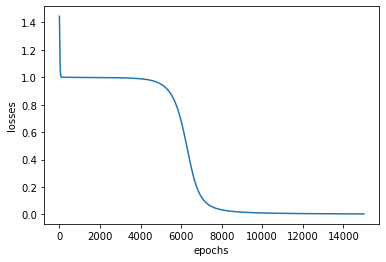

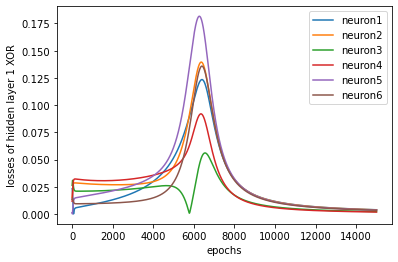

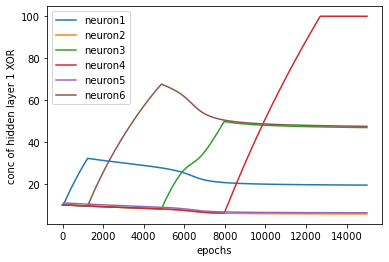

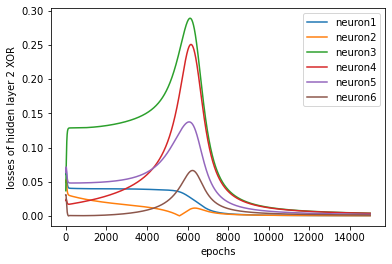

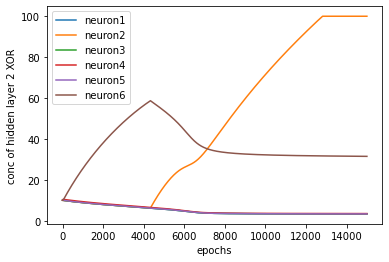

In [26]:
#plotting all the graphs here
plt.figure(1)
plt.xlabel('epochs')
plt.ylabel('losses')
plt.plot(np.arange(1, int(nepochs+2)), np.array(nn.finalloss))
plt.savefig(folder+'losses_overall.png')

#losses of hidden layer 1
plt.figure(2)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 1 XOR')
plt.plot(np.arange(1,int(nepochs+2)),np.array(nn.losses[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h1.png')

#concentration values of hidden layer 1
plt.figure(3)
plt.xlabel('epochs')
plt.ylabel('conc of hidden layer 1 XOR')
plt.plot(np.arange(1,int(nepochs+2)),np.array(nn.concvalues[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'conc_h1.png')

#losses of hidden layer 2
plt.figure(4)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 2 XOR')
plt.plot(np.arange(1,int(nepochs+2)),np.array(nn.losses[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h2.png')

#concentration values of hidden layer 2
plt.figure(5)
plt.xlabel('epochs')
plt.ylabel('conc of hidden layer 2 XOR')
plt.plot(np.arange(1,int(nepochs+2)),np.array(nn.concvalues[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'conc_h2.png')

In [29]:
onn=XOR_NN([2,6,6,1])
oinputs = np.array([[0,0],[0,1],[1,0],[1,1]])
#oaoutputs= np.array([[0.0],[1.0],[1.0],[1.0]]) #this is OR
oaoutputs= np.array([[0.0],[0.0],[0.0],[1.0]]) #AND
#oaoutputs= np.array([[0.0],[1.0],[1.0],[0.0]]) #XOR
folder=master_folder+'AND/'
print('weights are \n',onn.weights)

weights are 
 [array([[ 0.2728228 ,  0.33631287,  0.71185716, -0.63535729,  0.64917246,
         0.75410671],
       [ 0.83820145, -0.85319934,  0.48221279,  0.83756968,  0.38905922,
        -0.88875005]]), array([[-0.18285017,  0.64545644, -0.39112814,  0.89280792, -0.63622073,
         0.07685058],
       [-0.64425004,  0.30350309,  0.77514934, -0.63972077,  0.77022121,
        -0.80503944],
       [ 0.64546901,  0.28015973,  0.56084244, -0.07017389, -0.85586783,
         0.78102528],
       [-0.07574341,  0.79865754, -0.1147454 , -0.07759132,  0.87678407,
         0.0647582 ],
       [ 0.99429198,  0.38296668, -0.00949371, -0.95681881,  0.35762362,
        -0.45691898],
       [-0.02383297, -0.22245465,  0.09684259,  0.89946024, -0.30526284,
        -0.53717993]]), array([[-0.83723871],
       [-0.27876425],
       [-0.2350506 ],
       [ 0.09950045],
       [-0.1043396 ],
       [-0.68415999]])]


In [30]:
onepochs=15000
onn.fit(oinputs, oaoutputs,epochs=onepochs)

Error at the epoch 1 is 0.7735840799808422
Error at the epoch 5001 is 0.00726946304753317
Error at the epoch 10001 is 0.001976873247022965
Error at the epoch 15001 is 0.001082141923423103


In [31]:
savetxt(folder+'losses_overall.csv',onn.finalloss,delimiter=',')
savetxt(folder+'losses_h1.csv',onn.losses[0],delimiter=',')
savetxt(folder+'losses_h2.csv',onn.losses[1],delimiter=',')

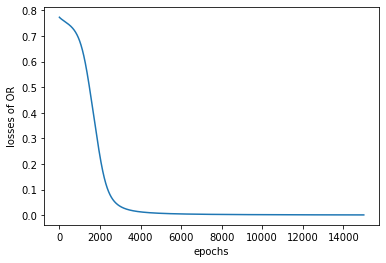

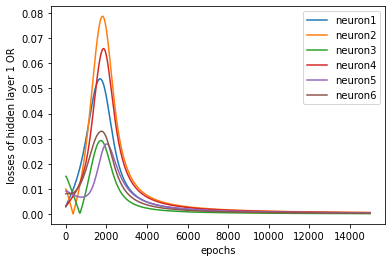

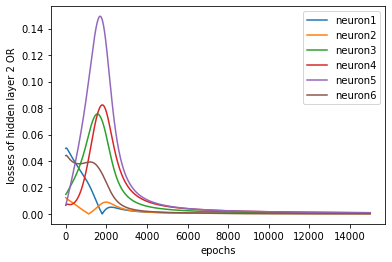

In [32]:
#plotting all the graphs here
plt.figure(1)
plt.xlabel('epochs')
plt.ylabel('losses of OR')
plt.plot(np.arange(1, int(onepochs+2)), np.array(onn.finalloss))
plt.savefig(folder+'losses_overall.png')

#losses of hidden layer 1
plt.figure(2)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 1 OR')
plt.plot(np.arange(1,int(onepochs+2)),np.array(onn.losses[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h1.png')

#there is no concentration values in this version

#losses of hidden layer 2
plt.figure(3)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 2 OR')
plt.plot(np.arange(1,int(onepochs+2)),np.array(onn.losses[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h2.png')

#there are no concentration values in the is version

In [33]:
w_back=copy.deepcopy(nn.weights)
'''for layer in range(nn.layers-1):
    w=2*np.random.rand(nn.nn[layer], nn.nn[layer+1]) - 1
    w_back.append(w)'''
print(w_back)
w_maxargs=[]
w_minargs=[]
print('******************')
for i in range(len(nn.weights)-1):
    #print('i is ',i)
    #print(nn.conc[i])
    #now to select the two highest values of the concentration
    #whole array
    #print('sorted',nn.conc[i].argsort())
    tempcmax=nn.conc[i].argsort()[-4:][::-1]
    w_maxargs.append(tempcmax)
    #print('tempc max is ',tempcmax)
    tempcmin=nn.conc[i].argsort()[:2]
    w_minargs.append(tempcmin)
    print('tempc min is ',tempcmin)
    #print('w is ',w_back[i+1])
    for j in tempcmin:
        #print(w_back[i+1])
        #print('j is ',j)
        #print(w_back[i][:,j])
        w_back[i][:,j]=(2*np.random.rand(w_back[i][:,j].size) - 1)
print(w_back)
print(w_maxargs)
print(w_minargs)

[array([[ 4.35155588, -0.11068284,  0.13206305, -3.80224199, -1.88575546,
         2.46497167],
       [ 4.42229522,  0.12353546,  0.25721285,  1.77542791,  4.07617253,
        -1.1774037 ]]), array([[ 0.30454029,  0.96035811,  5.3027569 , -4.36404621, -2.33899155,
         1.84471983],
       [ 0.37785948,  0.37061148, -2.21222469,  0.75071991,  1.25225577,
        -1.09479909],
       [-0.69968065, -0.05147041, -1.44269105,  0.85022807, -0.0214899 ,
        -0.64065423],
       [-0.2916886 , -0.71824674,  1.96876088, -1.23352117, -0.35057846,
         0.4974537 ],
       [-0.04362874, -0.72400506, -3.4565229 ,  3.17739401,  0.89841369,
        -0.28227574],
       [ 1.10900498, -0.4614193 , -1.92385469,  2.15540494,  1.26984607,
        -0.8367244 ]]), array([[-0.52980994],
       [ 0.4875081 ],
       [ 7.23008409],
       [-6.47894111],
       [-3.38480039],
       [ 1.81153544]])]
******************
tempc min is  [1 4]
tempc min is  [0 2]
[array([[ 4.35155588,  0.60609182,  0.1320

In [34]:
trans_weights=copy.deepcopy(nn.weights)

In [35]:
class TRANSFER_NN:
    def __init__(self,nn):
        self.activation=sigmoid
        self.derivative_act=sigmoid_derivative
        self.layers=len(nn)
        self.steps_per_epoch=1
        self.nn=nn
        self.weights= []
        self.losses=[]
        self.finalloss=[]
        self.bias=[]
        self.conc=[]
        self.concvalues=[]

        for layer in range(self.layers - 1):
            w=2*np.random.rand(nn[layer], nn[layer+1]) - 1
            b=np.random.random(size=(1,nn[layer+1]))
            self.weights.append(w)
            self.bias.append(b)
            concarray=np.ma.array(np.full((nn[layer+1]),init_conc),mask=False)
            self.conc.append(concarray)
            self.losses.append([])
            self.concvalues.append([])

    def _forward_prop(self,x):
        y=[x]
        for i in range(len(self.weights)-1):
            if i==0:
                dotprod=np.dot(x,self.weights[i])
            else:
                dotprod=np.dot(y[i],self.weights[i])
          #dotprod+=self.bias[i]
            activate=self.activation(dotprod)
            y.append(activate)

        #last layer
        dotprod=np.dot(y[-1],self.weights[-1])
        activate=self.activation(dotprod)
        y.append(activate)
        return y

    #here starts the backpropagation
    def _backprop_res(self,y,target,lr,iflag=False):
        error=target-y[-1]
        deltavec=[error*self.derivative_act(y[-1])]
        lerror=error
        lerrorsum=np.sum(error**2)
        errorvec=[lerrorsum]
        esumvec=[]
        esumvecg=[]

        for i in range(self.layers-2,0,-1):
            error=deltavec[-1].dot(self.weights[i].T)
            onlyerror=error
            error=error*self.derivative_act(y[i])
            esum=abs(np.sum(error,axis=0))
            esumg=abs(np.sum(abs(error),axis=0))
            deltavec.append(error)
            errorvec.append(onlyerror)
            esumvec.append(esum)
            esumvecg.append(esumg)

        deltavec.reverse()
        errorvec.reverse()
        esumvec.reverse()
        esumvecg.reverse()
        #print('The errorsum vector is ',esumvec)
        
        #calculating the stimulations and the suppressions before the updation of weights
        for i in range(len(self.weights)-1):
            self.losses[i].append(esumvecg[i].tolist())
            if iflag==True:
                #print('***************************************************')
                #print("the index is ",i)
                #print('losses is ',self.losses)
                #this is the sum of concentration values
                sumc=np.sum(self.conc[i])
                #this is the index of the minimum concentration value
                mini=(np.argmin(esumvecg[i])).item()
                #print('the sum of concentration values is ',sumc)
                #print('min index is ',mini)
                self.conc[i].mask[mini]=True
                #print('conc array after masking ',self.conc[i])
                sti=[]
                deltac=[]
                minsum=beta*(np.sum(self.conc[i])/sumc)
                #print('minsum is ',minsum)
                self.conc[i].mask[mini]=False #after taking the sum setting the mask back to false
                #print('conc array after unmasking ',self.conc[i])
                sti=beta*(self.conc[i]/sumc)
                #print('sti is ',sti)
                self.conc[i].mask[mini]=True
                deltacn=-1*abs(abs(np.sum(esumvecg[i])))*sti
                self.conc[i]+=deltacn
                deltacnmin=abs(1-abs(np.sum(esumvecg[i])))*minsum
                #print('deltacnmin is ',deltacnmin)
                self.conc[i].mask[mini]=False
                self.conc[i][mini]+=deltacnmin
                #self.conc[i] = np.ma.where(self.conc[i] < 30.00, self.conc[i], 30.00)
                #print('after sti and sup conc is ',self.conc[i])
                self.conc[i]=np.ma.array(np.ma.where(self.conc[i]>100.0,100.0,self.conc[i]),mask=False)
                #print('selfconc is ',self.conc[i])
                self.concvalues[i].append((self.conc[i].copy()).tolist())

            #using deep copy
            #self.reshist.append(copy.deepcopy(self.res))
        
        #here now updating the weights
        for i in range(len(self.weights)):
            self.weights[i]+=lr*(y[i].T.dot(deltavec[i]))
            #self.bias[i]+=np.sum(deltavec[i],axis=0,keepdims=True)*lr
        for i in range(len(self.weights)-1):
            for j in w_maxargs[i]:
                self.weights[i][:,j]=trans_weights[i][:,j]

        return lerrorsum

    def fit(self,data,labels,learning_rate=0.1,epochs=100000,iflag=False):
        x=data
        for i in range(epochs+1):
            y=self._forward_prop(x)
            #print('y[-1] after forward prop',y[-1])
            error=self._backprop_res(y,labels,learning_rate,iflag)
            self.finalloss.append(error)
            if(i)%5000==0:
                print(f"Error at the epoch {i+1} is {error}")

In [36]:
folder=master_folder+'AND_IN_Transfer/'
ox=TRANSFER_NN([2,6,6,1])
ox.weights=copy.deepcopy(w_back)
oinputs = np.array([[0,0],[0,1],[1,0],[1,1]])
#oaoutputs= np.array([[0.0],[1.0],[1.0],[1.0]]) #OR
oaoutputs= np.array([[0.0],[0.0],[0.0],[1.0]]) #AND
#oaoutputs= np.array([[0.0],[1.0],[1.0],[0.0]]) #XOR

In [37]:
oxnepochs=15000
ox.fit(oinputs, oaoutputs,epochs=onepochs,iflag=True)

Error at the epoch 1 is 1.7060829557797152
Error at the epoch 5001 is 0.0059196493189345965
Error at the epoch 10001 is 0.002544525133288536
Error at the epoch 15001 is 0.0015598310618991284


In [38]:
a=(ox._forward_prop(inputs))
print(a[-1])

[[5.86564550e-05]
 [2.63460098e-02]
 [1.28382678e-02]
 [9.73527957e-01]]


In [39]:
savetxt(folder+'losses_overall.csv',ox.finalloss,delimiter=',')
savetxt(folder+'losses_h1.csv',ox.losses[0],delimiter=',')
savetxt(folder+'losses_h2.csv',ox.losses[1],delimiter=',')
savetxt(folder+'conc_h1.csv',ox.concvalues[0],delimiter=',')
savetxt(folder+'conc_h2.csv',ox.concvalues[1],delimiter=',')

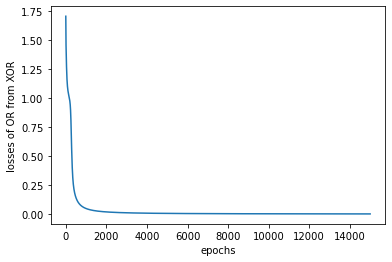

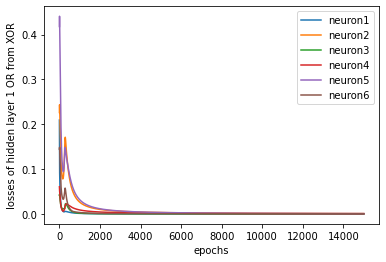

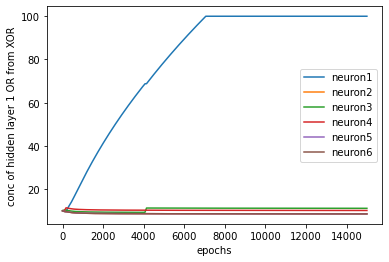

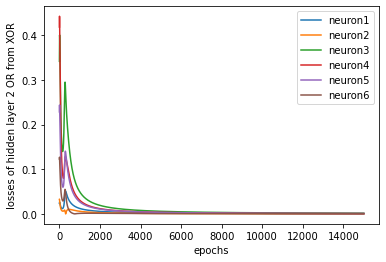

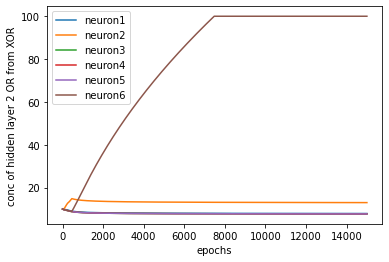

In [40]:
#plotting all the graphs here
plt.figure(1)
plt.xlabel('epochs')
plt.ylabel('losses of OR from XOR')
plt.plot(np.arange(1, oxnepochs+2), np.array(ox.finalloss))
plt.savefig(folder+'losses_overall.png')

#losses of hidden layer 1
plt.figure(2)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 1 OR from XOR')
plt.plot(np.arange(1,int(oxnepochs+2)),np.array(ox.losses[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h1.png')

#concentration values of hidden layer 1
plt.figure(3)
plt.xlabel('epochs')
plt.ylabel('conc of hidden layer 1 OR from XOR')
plt.plot(np.arange(1,int(oxnepochs+2)),np.array(ox.concvalues[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'conc_h1.png')

#losses of hidden layer 2
plt.figure(4)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 2 OR from XOR')
plt.plot(np.arange(1,int(oxnepochs+2)),np.array(ox.losses[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h2.png')

#concentration values of hidden layer 2
plt.figure(5)
plt.xlabel('epochs')
plt.ylabel('conc of hidden layer 2 OR from XOR')
plt.plot(np.arange(1,int(oxnepochs+2)),np.array(ox.concvalues[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'conc_h2.png')

In [ ]:
print('XOR')
for i in range(len(nn.weights)-1):
    tempcmax=nn.conc[i].argsort()[-3:][::-1]
    #print('tempc max is ',tempcmax)
    tempcmin=nn.conc[i].argsort()[:3]
    #print(nn.conc[i])
    #print('tempc max is ',tempcmax)
print(w_maxargs)
w_maxargs_after=[]
print('**************')
print('OR after XOR')
for i in range(len(ox.weights)-1):
    tempcmax=ox.conc[i].argsort()[-3:][::-1]
    w_maxargs_after.append(tempcmax)
    #print('tempc max is ',tempcmax)
    tempcmin=ox.conc[i].argsort()[:3]
    #print(ox.conc[i])
    #print('tempc max is ',tempcmax)
print(w_maxargs_after)

In [41]:
folder=master_folder+'AND_TotalTransfer/'
oan=XOR_NN([2,6,6,1])
oan.weights=copy.deepcopy(nn.weights)
ainputs = np.array([[0,0],[0,1],[1,0],[1,1]])
aaoutputs= np.array([[0.0],[0.0],[0.0],[1.0]]) #AND
#aaoutputs= np.array([[0.0],[1.0],[1.0],[0.0]]) #XOR
#aaoutputs= np.array([[0.0],[1.0],[1.0],[1.0]]) #OR

In [42]:
oannepochs=15000
oan.fit(ainputs, aaoutputs,epochs=oannepochs)

Error at the epoch 1 is 2.847206103097257
Error at the epoch 5001 is 0.9998553144682183
Error at the epoch 10001 is 0.9998147693302126
Error at the epoch 15001 is 0.9997742897916302


In [43]:
savetxt(folder+'losses_overall.csv',oan.finalloss,delimiter=',')
savetxt(folder+'losses_h1.csv',oan.losses[0],delimiter=',')
savetxt(folder+'losses_h2.csv',oan.losses[1],delimiter=',')

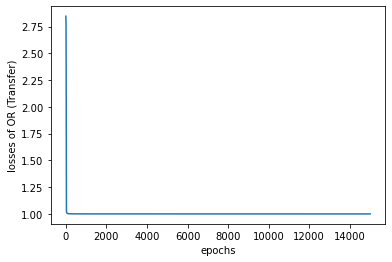

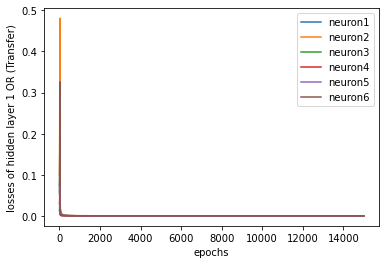

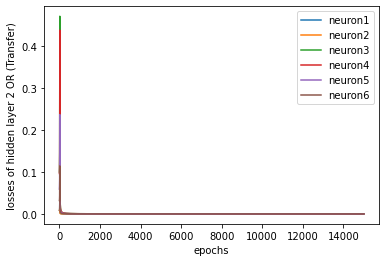

In [44]:
#plotting all the graphs here
plt.figure(1)
plt.xlabel('epochs')
plt.ylabel('losses of OR (Transfer)')
plt.plot(np.arange(1, int(oannepochs+2)), np.array(oan.finalloss))
plt.savefig(folder+'losses_overall.png')

#losses of hidden layer 1
plt.figure(2)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 1 OR (Transfer)')
plt.plot(np.arange(1,int(oannepochs+2)),np.array(oan.losses[0]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h1.png')

#there is no concentration values in this version

#losses of hidden layer 2
plt.figure(3)
plt.xlabel('epochs')
plt.ylabel('losses of hidden layer 2 OR (Transfer)')
plt.plot(np.arange(1,int(oannepochs+2)),np.array(oan.losses[1]))
plt.legend(['neuron1','neuron2','neuron3','neuron4','neuron5','neuron6'])
plt.savefig(folder+'losses_h2.png')
#there are no concentration values in the is version

In [ ]:
a=(oan._forward_prop(inputs))
print(a[-1])

In [ ]:
#savetxt('./logs/8Jan_t1/XOR/weights_XOR.txt',nn.weights[0],delimiter=', ')
file1=open(master_folder+'XOR/weights_XOR.txt','w+')
file1.writelines(str(nn.weights))
file1=open(master_folder+'AND/weights_AND.txt','w+')
file1.writelines(str(onn.weights))
file1=open(master_folder+'AND_IN_Transfer/weights_AND_IN_Transfer.txt','w+')
file1.writelines(str(ox.weights))
file1=open(master_folder+'AND_TotalTransfer/weights_AND_TotalTransfer.txt','w+')
file1.writelines(str(oan.weights))

In [ ]:
#complete hardcoding here
print(w_maxargs_after)
print(w_maxargs)
newweights=[]
losses_XOR=[]
losses_AND=[]
newnn=[2,10,10,1]
for layer in range(3):
    w=2*np.random.rand(newnn[layer], newnn[layer+1]) - 1
    newweights.append(w)
    losses_XOR.append([])
    losses_AND.append([])
#print(newweights)
print(newweights[1].shape)
print('******')
print(nn.weights[1].shape)
#in hidden layer 1 - [array([2, 1, 5]), array([2, 4, 5])] - doing for 2 and 5 
#for last two indices 4 and 5 for first gate - XOR - this will be first two indices for second gate AND
newweights[0][:,4]=copy.deepcopy(nn.weights[0][:,1])
newweights[0][:,5]=copy.deepcopy(nn.weights[0][:,5])
print('done')
#in hidden layer 2 - [array([0, 1, 4]), array([1, 4, 3])] - doing for 1 and 4 
#for last two indices 4 and 5 for first gate - XOR - this will be first two indices for second gate AND
newweights[1][:6,4]=copy.deepcopy(nn.weights[1][:,4])
newweights[1][:6,5]=copy.deepcopy(nn.weights[1][:,5])

inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
aoutputs= np.array([[0.0],[1.0],[1.0],[0.0]])
oaoutputs= np.array([[0.0],[0.0],[0.0],[1.0]])




In [ ]:
#this is for layer 0
'''print(newweights[0][:,:6])  #XOR
print(newweights[0][:,:])
print(newweights[0][:,4:])  #AND'''

#this is for layer 1
print(newweights[-1][:6,:6])  #XOR
print('********************')
print(newweights[1][:,:])
print('********************')
#print(newweights[1][4:,4:])  #AND newweights[-1][4:,4:]
print(newweights[-1][4:,:])

In [ ]:
#forward prop for XOR

finalloss_XOR=[]
finalloss_AND=[]
layers=4
def forward_prop_cxor(x):
        y=[x]
        for i in range(len(newweights)-1):
            #print('********************')
            #print('The index i is ',i)
            if i==0:
                dotprod=np.dot(x,newweights[i][:,:6])
            else:
                #print('y[i] is ',y[i])
                dotprod=np.dot(y[i],newweights[i][:6,:6])
          #dotprod+=self.bias[i]
            activate=nn.activation(dotprod)
            y.append(activate)
            #print('y[i+1] is ',y[i+1])

        #last layer
        dotprod=np.dot(y[-1],newweights[-1][:6,:6])
        activate=nn.activation(dotprod)
        y.append(activate)
        return y

def backward_prop_cxor(y,target,lr,iflag=False):
    error=target-y[-1]
    deltavec=[error*nn.derivative_act(y[-1])]
    lerror=error
    lerrorsum=np.sum(error**2)
    errorvec=[lerrorsum]
    esumvec=[]
    
    for i in range(layers-2,0,-1):
        error=deltavec[-1].dot(newweights[i][:6,:6].T)
        onlyerror=error
        error=error*nn.derivative_act(y[i])
        esum=abs(np.sum(error,axis=0))
        deltavec.append(error)
        errorvec.append(onlyerror)
        esumvec.append(esum)

    deltavec.reverse()
    errorvec.reverse()
    esumvec.reverse()
    
    for i in range(len(newweights)-1):
        losses_XOR[i].append(esumvec[i].tolist())
    for i in range(len(newweights)):
        newweights[i][:6,:6]+=lr*(y[i].T.dot(deltavec[i]))
    return lerrorsum

#forward prop AND
def forward_prop_cand(x):
        y=[x]
        for i in range(len(newweights)-1):
            #print('********************')
            #print('The index i is ',i)
            if i==0:
                dotprod=np.dot(x,newweights[i][:,4:])
            else:
                #print('y[i] is ',y[i])
                dotprod=np.dot(y[i],newweights[i][4:,4:])
          #dotprod+=self.bias[i]
            activate=nn.activation(dotprod)
            y.append(activate)
            #print('y[i+1] is ',y[i+1])

        #last layer
        dotprod=np.dot(y[-1],newweights[-1][4:,:])
        activate=nn.activation(dotprod)
        y.append(activate)
        return y

def backward_prop_cand(y,target,lr,iflag=False):
    error=target-y[-1]
    deltavec=[error*nn.derivative_act(y[-1])]
    lerror=error
    lerrorsum=np.sum(error**2)
    errorvec=[lerrorsum]
    esumvec=[]
    
    for i in range(layers-2,0,-1):
        
        if i==2:
            error=deltavec[-1].dot(newweights[i][4:,:].T)
        else:
            error=deltavec[-1].dot(newweights[i][4:,4:].T)
        onlyerror=error
        error=error*nn.derivative_act(y[i])
        esum=abs(np.sum(error,axis=0))
        deltavec.append(error)
        errorvec.append(onlyerror)
        esumvec.append(esum)

    deltavec.reverse()
    errorvec.reverse()
    esumvec.reverse()
    #print('deltavec is ',deltavec)
    
    for i in range(len(newweights)-1):
        losses_AND[i].append(esumvec[i].tolist())
    for i in range(len(newweights)):
        #print('i is ',i)
        if i==0:
            #print('printing ',newweights[i])
            newweights[i][:,4:]+=lr*(y[i].T.dot(deltavec[i]))
        else:
            #print(newweights[i][4:,4:])
            newweights[i][4:,4:]+=lr*(y[i].T.dot(deltavec[i]))
    return lerrorsum
    
yxor=forward_prop_cxor(inputs)
yand=forward_prop_cand(inputs)
print('yxor is ',yxor)
print('*****************')
print('yand is ',yand)
errxor=backward_prop_cxor(yxor,aoutputs,lr=0.1)
errand=backward_prop_cand(yand,oaoutputs,lr=0.1)
print(errxor)
print(errand)

In [ ]:
final_losses_xor=[]
final_losses_and=[]
fepochs=150000
def merge_fit(data,labels_xor,labels_and,learning_rate=0.1,epochs=100000,iflag=False):
        x_xor=data
        x_and=data
        for i in range(epochs+1):
            yxor=forward_prop_cxor(x_xor)
            error_xor=backward_prop_cand(yxor,labels_xor,learning_rate,iflag)
            final_losses_xor.append(error_xor)
            #----------------------
            yand=forward_prop_cand(x_and)
            error_and=backward_prop_cand(yand,labels_and,learning_rate,iflag)
            final_losses_and.append(error_and)
            if(i)%5000==0:
                print(f"Error at the epoch {i+1} is XOR {error_xor} and AND {error_and}")
merge_fit(inputs,aoutputs,oaoutputs,epochs=fepochs,iflag=True)